In [16]:
# Block range in the original article: 4605167 to 5374870
# Filtering by block_timestamp is more cost efficient than by block_number because the tables are partitioned by block_timestamp
# block_number = 4605167 -> block_timestamp == "2017-11-23 05:41:19" 
# block_number = 5374870 -> block_timestamp == "2018-04-03 19:53:46" 

FROM_BLOCK = 4605167
TO_BLOCK = 5374870
FROM_BLOCK_TIMESTAMP = "'2018-01-01 05:41:19'" # "'2017-11-23 05:41:19'"
TO_BLOCK_TIMESTAMP = "'2018-04-03 19:53:46'"
MY_TIMEOUT = 300

# relevant Events signatures
events_signatures = {
    'AuctionCreated' : 'AuctionCreated(uint256,uint256,uint256,uint256)', # AuctionCreated(uint256 tokenId, uint256 startingPrice, uint256 endingPrice, uint256 duration);
    'AuctionSuccessful' : 'AuctionSuccessful(uint256,uint256,address)', # AuctionSuccessful(uint256 tokenId, uint256 totalPrice, address winner);
    'AuctionCancelled' : 'AuctionCancelled(uint256)', # AuctionCancelled(uint256 tokenId);
    'Pause' : 'Pause()',
    'Unpause' : 'Unpause()',
    'Transfer' : 'Transfer(address,address,uint256)', # Transfer(address from, address to, uint256 tokenId);
    'Approval' : 'Approval(address,address,uint256)', # Approval(address owner, address approved, uint256 tokenId);
    'ContractUpgrade' : 'ContractUpgrade(address)',
    'Birth' : 'Birth(address,uint256,uint256,uint256,uint256)', # Birth(address owner, uint256 kittyId, uint256 matronId, uint256 sireId, uint256 genes);
    'Pregnant' : 'Pregnant(address,uint256,uint256,uint256)' # Pregnant(address owner, uint256 matronId, uint256 sireId, uint256 cooldownEndBlock);
}
events_hashes = {'0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5': 'Birth',
 '241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80': 'Pregnant',
 '2809c7e17bf978fbc7194c0a694b638c4215e9140cacc6c38ca36010b45697df': 'AuctionCancelled',
 '450db8da6efbe9c22f2347f7c2021231df1fc58d3ae9a2fa75d39fa446199305': 'ContractUpgrade',
 '4fcc30d90a842164dd58501ab874a101a3749c3d4747139cefe7c876f4ccebd2': 'AuctionSuccessful',
 '6985a02210a168e66602d3235cb6db0e70f92b3ba4d376a33c0f3d9434bff625': 'Pause',
 '7805862f689e2f13df9f062ff482ad3ad112aca9e0847911ed832e158c525b33': 'Unpause',
 '8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925': 'Approval',
 'a9c8dfcda5664a5a124c713e386da27de87432d5b668e79458501eb296389ba7': 'AuctionCreated',
 'ddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef': 'Transfer'}
coreContract = '0x06012c8cf97bead5deae237070f9587f8e7a266d'
contracts = {
    coreContract : 'core',
    '0xc7af99fe5513eb6710e6d5f44f9989da40f27f26' : 'siringAuction',
    '0xb1690c08e213a35ed9bab7b318de14420fb57d8c' : 'saleAuction',
}


In [17]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_colwidth', 70)

In [18]:
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file(
    './bitcoincurso-77637377e186.json', scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)
query = """
SELECT 
  transaction_hash AS transactionHash,
  address,
  data,
  topics,
  block_timestamp,
  block_number AS blockNumber_dec
FROM
  `bigquery-public-data.ethereum_blockchain.logs` AS events
WHERE TRUE
  AND block_timestamp >= {from_block_ts} 
  AND block_timestamp <= {to_block_ts}
  AND address IN ({contract_list})
""".format(from_block_ts=FROM_BLOCK_TIMESTAMP, to_block_ts=TO_BLOCK_TIMESTAMP, contract_list="'0x06012c8cf97bead5deae237070f9587f8e7a266d','0xc7af99fe5513eb6710e6d5f44f9989da40f27f26','0xb1690c08e213a35ed9bab7b318de14420fb57d8c'")
print(query)
query_job = client.query(query)
iterator = query_job.result(timeout=MY_TIMEOUT)
rows = list(iterator)
events = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
events['contract'] = events['address'].apply(lambda x: contracts[x])
events['event'] = events['topics'].apply(lambda x: events_hashes[x[0][2:]])
events.head(10)


SELECT 
  transaction_hash AS transactionHash,
  address,
  data,
  topics,
  block_timestamp,
  block_number AS blockNumber_dec
FROM
  `bigquery-public-data.ethereum_blockchain.logs` AS events
WHERE TRUE
  AND block_timestamp >= '2018-01-01 05:41:19' 
  AND block_timestamp <= '2018-04-03 19:53:46'
  AND address IN ('0x06012c8cf97bead5deae237070f9587f8e7a266d','0xc7af99fe5513eb6710e6d5f44f9989da40f27f26','0xb1690c08e213a35ed9bab7b318de14420fb57d8c')



,transactionHash,address,data,topics,block_timestamp,blockNumber_dec,contract,event
0,0x78bc5e5e1052dcefcfa0f67bb4af92e9a84684d517c1f8e208ce2fa84547fe27,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x000000000000000000000000c5f7bce9a3aff9e61b0a1c69e3e77487c8bf9a91...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],2018-03-28 02:10:20+00:00,5334528,core,Transfer
1,0x78bc5e5e1052dcefcfa0f67bb4af92e9a84684d517c1f8e208ce2fa84547fe27,0xb1690c08e213a35ed9bab7b318de14420fb57d8c,0x000000000000000000000000000000000000000000000000000000000009e8c7...,[0xa9c8dfcda5664a5a124c713e386da27de87432d5b668e79458501eb296389ba7],2018-03-28 02:10:20+00:00,5334528,saleAuction,AuctionCreated
2,0xc9fd0d2d3110cebd98736377f42bbe513ac522f4db38e2df9e451f2b558c48f1,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x00000000000000000000000068b42e44079d1d0a4a037e8c6ecd62c48967e69f...,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],2018-03-28 03:12:29+00:00,5334784,core,Pregnant
3,0xdd4b94eb6ec4cb34bd0b87b204af47e795d61d6d2c388617a9522ca88ab5f74c,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x000000000000000000000000a096b47ebf7727d01ff4f09c34fc6591f2c375f0...,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],2018-03-28 03:12:29+00:00,5334784,core,Pregnant
4,0x4f0bf64988bf80c10c09f56b48164e7c668dd077dbeb7305b282939a846f811c,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x000000000000000000000000005ab08778b49154462c494d8cf79e97e3b15de3...,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],2018-03-28 05:17:10+00:00,5335296,core,Birth
5,0x4f0bf64988bf80c10c09f56b48164e7c668dd077dbeb7305b282939a846f811c,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x0000000000000000000000000000000000000000000000000000000000000000...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],2018-03-28 05:17:10+00:00,5335296,core,Transfer
6,0xffab0880bdef254a34df68e21f96a12c039a1bb51b16c3a4d6c80c01a5214551,0xb1690c08e213a35ed9bab7b318de14420fb57d8c,0x000000000000000000000000000000000000000000000000000000000001cfce...,[0x4fcc30d90a842164dd58501ab874a101a3749c3d4747139cefe7c876f4ccebd2],2018-03-28 05:17:10+00:00,5335296,saleAuction,AuctionSuccessful
7,0xffab0880bdef254a34df68e21f96a12c039a1bb51b16c3a4d6c80c01a5214551,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x000000000000000000000000b1690c08e213a35ed9bab7b318de14420fb57d8c...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],2018-03-28 05:17:10+00:00,5335296,core,Transfer
8,0xde975170dee7bd56a1dc894175370d8bc076f2048213a4bed45cd75f69074c3f,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x000000000000000000000000f74cff3195be4b5bebe057a8d4c62641de5b8d00...,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],2018-03-28 06:23:46+00:00,5335552,core,Birth
9,0xde975170dee7bd56a1dc894175370d8bc076f2048213a4bed45cd75f69074c3f,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x0000000000000000000000000000000000000000000000000000000000000000...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],2018-03-28 06:23:46+00:00,5335552,core,Transfer


In [19]:
print('Block range: ' + str(events.blockNumber_dec.min()) + ' to ' + str(events.blockNumber_dec.max()))


Block range: 4834131 to 5374870


In [20]:
events.groupby(['contract','event']).transactionHash.count()

contract       event            
core           Approval                492
               Birth                223836
               Pregnant             214910
               Transfer             663468
saleAuction    AuctionCancelled      43213
               AuctionCreated       182661
               AuctionSuccessful     95481
siringAuction  AuctionCancelled      17709
               AuctionCreated        53632
               AuctionSuccessful     22538
Name: transactionHash, dtype: int64

<AxesSubplot:ylabel='contract,event'>

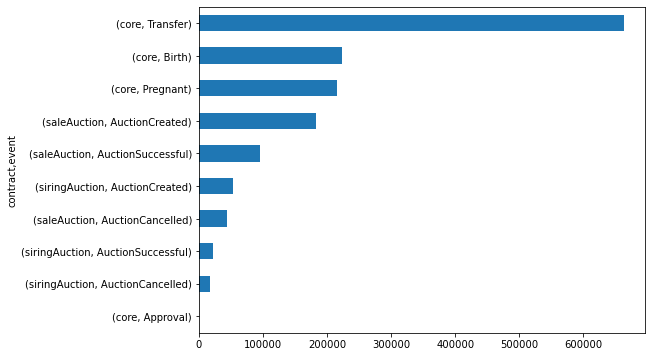

In [21]:
event_counts = events.groupby(['contract','event']).transactionHash.count()
event_counts.sort_values().plot(kind='barh', figsize=(8, 6))

In [22]:
event_counts_df = event_counts.reset_index()
event_counts_df.columns = ['contract', 'event', 'count']
event_counts_df


,contract,event,count
0,core,Approval,492
1,core,Birth,223836
2,core,Pregnant,214910
3,core,Transfer,663468
4,saleAuction,AuctionCancelled,43213
5,saleAuction,AuctionCreated,182661
6,saleAuction,AuctionSuccessful,95481
7,siringAuction,AuctionCancelled,17709
8,siringAuction,AuctionCreated,53632
9,siringAuction,AuctionSuccessful,22538


In [23]:
transfer_count = event_counts_df[event_counts_df['event']=='Transfer'].iloc[0]['count']

sale_auction_cancelled_count = event_counts_df[(event_counts_df['event']=='AuctionCancelled') & \
                                             (event_counts_df['contract']=='saleAuction')].iloc[0]['count']

siring_auction_cancelled_count = event_counts_df[(event_counts_df['event']=='AuctionCancelled') & \
                                             (event_counts_df['contract']=='siringAuction')].iloc[0]['count']

sale_auction_created_count = event_counts_df[(event_counts_df['event']=='AuctionCreated') & \
                                             (event_counts_df['contract']=='saleAuction')].iloc[0]['count']

siring_auction_created_count = event_counts_df[(event_counts_df['event']=='AuctionCreated') & \
                                             (event_counts_df['contract']=='siringAuction')].iloc[0]['count']

sale_auction_successful_count = event_counts_df[(event_counts_df['event']=='AuctionSuccessful') & \
                                             (event_counts_df['contract']=='saleAuction')].iloc[0]['count']

siring_auction_successful_count = event_counts_df[(event_counts_df['event']=='AuctionSuccessful') & \
                                             (event_counts_df['contract']=='siringAuction')].iloc[0]['count']

birth_count = event_counts_df[(event_counts_df['event']=='Birth')].iloc[0]['count']

pregnant_count = event_counts_df[(event_counts_df['event']=='Pregnant')].iloc[0]['count']


In [24]:
(transfer_count - \
sale_auction_cancelled_count - \
siring_auction_cancelled_count - \
sale_auction_created_count - \
siring_auction_created_count - \
sale_auction_successful_count - \
birth_count ) / \
transfer_count

0.0707434269625664

In [25]:
pregnant_count/siring_auction_successful_count

9.535451237909308

In [26]:


events['contract-event'] = events['contract'] + events['event']
events['block-group'] = events['blockNumber_dec'].apply(lambda x: int(x/1000))



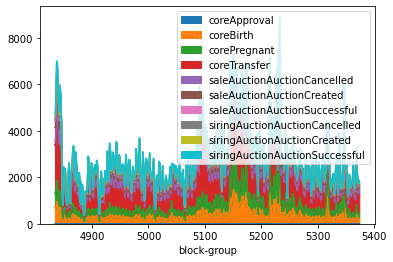

In [27]:
areaplot = events.groupby(['block-group','contract-event']).transactionHash.count().reset_index().pivot(index='block-group', columns='contract-event', values='transactionHash')#.plot.area()
areaplot.plot.area()
plt.legend(loc=1)

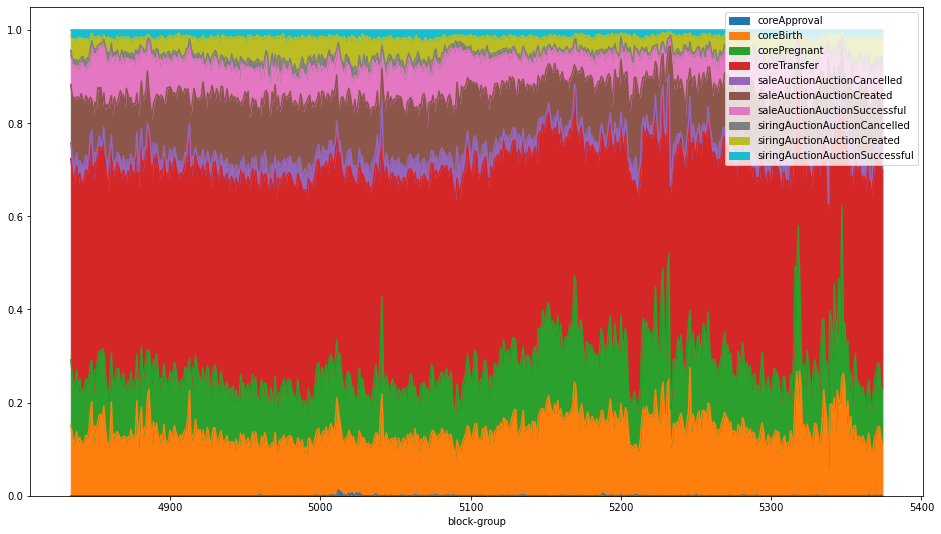

In [28]:
areaplot.divide(areaplot.sum(axis=1), axis=0).plot.area(figsize=(16, 9))
plt.legend(loc=1)


In [29]:


transaction_birthcount = (events[events['event']=='Birth'])[['transactionHash','event']].groupby(['transactionHash']).count().reset_index()
transaction_birthcount[transaction_birthcount['event']>1].head()



,transactionHash,event
4,0x0000cd3bc22d5ca6a1cff4271410ca10d4932b0be1c5d4a506c667ffb2b78495,2
10,0x00041b6212a6a999bbbc3decd35fc15cda40842165029e16a83e1f3e7f806438,3
12,0x0004dc10c50a3b8df3162875f37a357796bfbc6c7df7790a4b6b8cad764def09,2
14,0x000522002f2126e6384cb85452bc308e6d3a9c4d34280d2b2de767519f9863ff,2
19,0x000706aa6096001b526b5cab0da949968a544736b87cb7b13ef9523f2f736aea,2


In [30]:
query = """
SELECT 
  events.transaction_hash AS transactionHash,
  events.data,
  events.block_timestamp,
  events.block_number AS blockNumber_dec,
  txns.from_address AS midwife, 
  txns.to_address AS midwife_smartcontract, 
  txns.gas_price AS gasPrice, 
  txns.receipt_gas_used AS gasUsed
FROM
  `bigquery-public-data.ethereum_blockchain.logs` AS events
INNER JOIN
  `bigquery-public-data.ethereum_blockchain.transactions` AS txns
ON
  events.transaction_hash = txns.hash
WHERE TRUE
  AND events.block_timestamp >= {from_block_ts} 
  AND events.block_timestamp <= {to_block_ts}
  AND txns.block_timestamp >= {from_block_ts} --might seem redundant, but because of partitioning this reduces cost
  AND txns.block_timestamp <= {to_block_ts} --might seem redundant, but because of partitioning this reduces cost
  AND events.address = '0x06012c8cf97bead5deae237070f9587f8e7a266d'
  AND events.topics[OFFSET(0)] = '0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5'
""".format(from_block_ts=FROM_BLOCK_TIMESTAMP, 
           to_block_ts=TO_BLOCK_TIMESTAMP)
print(query)
query_job = client.query(query)
iterator = query_job.result(timeout=MY_TIMEOUT)
rows = list(iterator)
births = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
births.head(10)


SELECT 
  events.transaction_hash AS transactionHash,
  events.data,
  events.block_timestamp,
  events.block_number AS blockNumber_dec,
  txns.from_address AS midwife, 
  txns.to_address AS midwife_smartcontract, 
  txns.gas_price AS gasPrice, 
  txns.receipt_gas_used AS gasUsed
FROM
  `bigquery-public-data.ethereum_blockchain.logs` AS events
INNER JOIN
  `bigquery-public-data.ethereum_blockchain.transactions` AS txns
ON
  events.transaction_hash = txns.hash
WHERE TRUE
  AND events.block_timestamp >= '2018-01-01 05:41:19' 
  AND events.block_timestamp <= '2018-04-03 19:53:46'
  AND txns.block_timestamp >= '2018-01-01 05:41:19' --might seem redundant, but because of partitioning this reduces cost
  AND txns.block_timestamp <= '2018-04-03 19:53:46' --might seem redundant, but because of partitioning this reduces cost
  AND events.address = '0x06012c8cf97bead5deae237070f9587f8e7a266d'
  AND events.topics[OFFSET(0)] = '0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5'



,transactionHash,data,block_timestamp,blockNumber_dec,midwife,midwife_smartcontract,gasPrice,gasUsed
0,0xe48606d82b74bd937ebac34fd95ba3f6d0c9ba1d073d42f770ea038188f29433,0x000000000000000000000000e4398a848ef6f06d500e40f9e2042dcec426959c...,2018-03-11 19:04:36+00:00,5237773,0x682ed78859e2235e03535e11d2396e1e200bf0d4,0xccc1d3102703418cfda055ce688867268563b3e6,5100000000,273408
1,0xd78ba270e0acb2116cc18ca075572e878a37dbeaf1b1be17327508b9545c2543,0x000000000000000000000000aec539a116fa75e8bdcf016d3c146a25bc1af93b...,2018-03-11 23:36:37+00:00,5238927,0x62460a5567d2823781604dc938e0eaf073d24d9d,0xccc1d3102703418cfda055ce688867268563b3e6,5100000000,273666
2,0x46271a143770a735e80f49116dbbafeb33fba5856af4e757e39f9bfed27daaff,0x00000000000000000000000068b42e44079d1d0a4a037e8c6ecd62c48967e69f...,2018-03-11 00:16:36+00:00,5233141,0x62460a5567d2823781604dc938e0eaf073d24d9d,0xccc1d3102703418cfda055ce688867268563b3e6,5100000000,1228291
3,0x46271a143770a735e80f49116dbbafeb33fba5856af4e757e39f9bfed27daaff,0x00000000000000000000000068b42e44079d1d0a4a037e8c6ecd62c48967e69f...,2018-03-11 00:16:36+00:00,5233141,0x62460a5567d2823781604dc938e0eaf073d24d9d,0xccc1d3102703418cfda055ce688867268563b3e6,5100000000,1228291
4,0x46271a143770a735e80f49116dbbafeb33fba5856af4e757e39f9bfed27daaff,0x000000000000000000000000c6cefb75bee425978c7d91a84e20b1c688f9f5e8...,2018-03-11 00:16:36+00:00,5233141,0x62460a5567d2823781604dc938e0eaf073d24d9d,0xccc1d3102703418cfda055ce688867268563b3e6,5100000000,1228291
5,0x46271a143770a735e80f49116dbbafeb33fba5856af4e757e39f9bfed27daaff,0x000000000000000000000000c35a5fec6be6957899e15559be252db882220b37...,2018-03-11 00:16:36+00:00,5233141,0x62460a5567d2823781604dc938e0eaf073d24d9d,0xccc1d3102703418cfda055ce688867268563b3e6,5100000000,1228291
6,0x46271a143770a735e80f49116dbbafeb33fba5856af4e757e39f9bfed27daaff,0x00000000000000000000000068b42e44079d1d0a4a037e8c6ecd62c48967e69f...,2018-03-11 00:16:36+00:00,5233141,0x62460a5567d2823781604dc938e0eaf073d24d9d,0xccc1d3102703418cfda055ce688867268563b3e6,5100000000,1228291
7,0xd7e005163fafc5366960897b8eeae1a0e39025183631ef4bbc84da6bf9bb1a92,0x000000000000000000000000851379617ff466cbed666c4fa6dd95dcee2226bb...,2018-03-11 13:16:27+00:00,5236313,0x62460a5567d2823781604dc938e0eaf073d24d9d,0xccc1d3102703418cfda055ce688867268563b3e6,5100000000,279556
8,0x9aaa92d5e982215b567ab074e81446ace8ba39389f1bb8f4d5fa4c1579844e97,0x000000000000000000000000c1ed34e5fbbff4a7c00952e3ec9e9d9326d44295...,2018-03-11 17:01:58+00:00,5237263,0xe8a576d484c10bed29aed74d16d6958aa05f94aa,0xccc1d3102703418cfda055ce688867268563b3e6,5100000000,516869
9,0x9aaa92d5e982215b567ab074e81446ace8ba39389f1bb8f4d5fa4c1579844e97,0x00000000000000000000000005654ab554b50cb8d4db32c77050f1a24a0937af...,2018-03-11 17:01:58+00:00,5237263,0xe8a576d484c10bed29aed74d16d6958aa05f94aa,0xccc1d3102703418cfda055ce688867268563b3e6,5100000000,516869


In [31]:
births['owner'] = '0x' + births['data'].apply(lambda x: x[26:66])
births['kittyId'] = births['data'].apply(lambda x: x[66:130])
births['kittyId_dec'] = births['kittyId'].apply(lambda x: int(x,16))
births['matronId'] = births['data'].apply(lambda x: x[130:194])
births['matronId_dec'] = births['matronId'].apply(lambda x: int(x,16))
births['sireId'] = births['data'].apply(lambda x: x[194:258])
births['sireId_dec'] = births['sireId'].apply(lambda x: int(x,16))
births['kittyGenes'] = births['data'].apply(lambda x: x[258:322])
births['block-group'] = births['blockNumber_dec'].apply(lambda x: int(x/1000))



<AxesSubplot:>

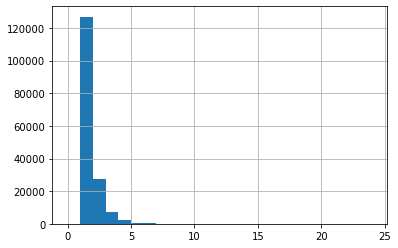

In [32]:
maxBirths = births.groupby(['transactionHash']).transactionHash.count().max()
births.groupby(['transactionHash']).transactionHash.count().hist(bins=range(maxBirths+2))

[https://medium.com/cryptokitties/cryptokitties-birthing-fees-increases-in-order-to-accommodate-demand-acc314fcadf5](https://medium.com/cryptokitties/cryptokitties-birthing-fees-increases-in-order-to-accommodate-demand-acc314fcadf5)

In [33]:
births['fee'] = births['gasUsed'] * births['gasPrice'] * 1E-18

In [34]:
AxiomZenAccounts = ['0xa21037849678af57f9865c6b9887f4e339f6377a','0xba52c75764d6f594735dc735be7f1830cdf58ddf']

In [35]:
allTimeTopMidwives = births.groupby(['midwife']).data.count().\
                sort_values(ascending=False)
len(allTimeTopMidwives)

251

In [36]:
allTimeTopMidwives = set(allTimeTopMidwives.head(10).index.values)
allTimeTopMidwives

{'0x05be6e1f661dacd4630e1ebe2ffce5bfb962076f',
 '0x6fc9bcb6091c01d6d2a530955e633b894ae48256',
 '0x74f42f97a229213343cbe0be747dfe4b705876cb',
 '0x80cfd274937d40c5e3d0e910a81d3330f3c10898',
 '0xa21037849678af57f9865c6b9887f4e339f6377a',
 '0xb7f819b983e0cbb0316786d7fba12e3b1e58da5f',
 '0xc5b373618d4d01a38f822f56ca6d2ff5080cc4f2',
 '0xd294209c4132b227902b03cf8c7c8d4d4a780eb4',
 '0xed9878336d5187949e4ca33359d2c47c846c9dd3',
 '0xf3461cc074cd21b60cbf393050c4990332215186'}

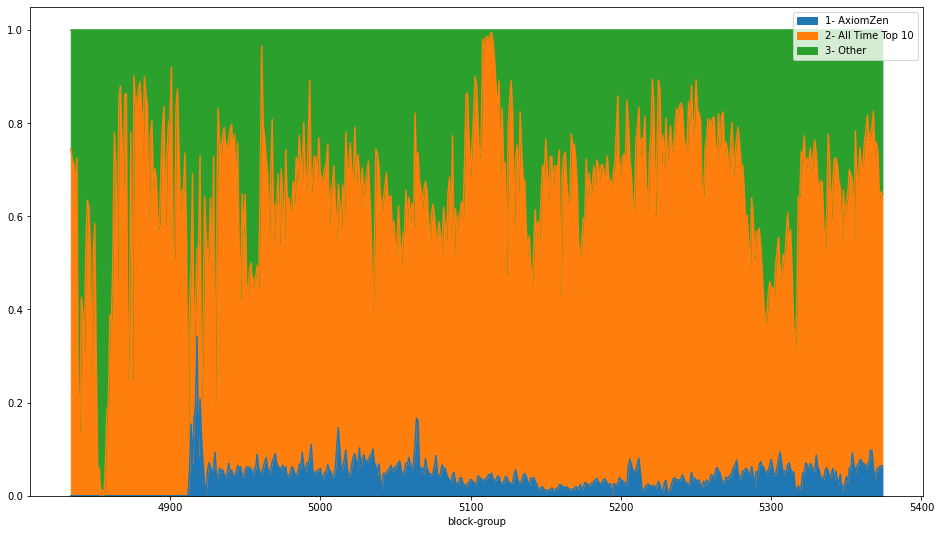

In [37]:
#
births['midwife-group'] = births['midwife'].apply(lambda x: '1- AxiomZen' \
                                                if x in AxiomZenAccounts \
                                                else '2- All Time Top 10' if x in allTimeTopMidwives \
                                                else '3- Other')
areaplot = births.groupby(['block-group','midwife-group']).transactionHash.count().reset_index().pivot(index='block-group', columns='midwife-group', values='transactionHash')
areaplot.divide(areaplot.sum(axis=1), axis=0).plot.area(figsize=(16, 9))
plt.legend(loc=1)

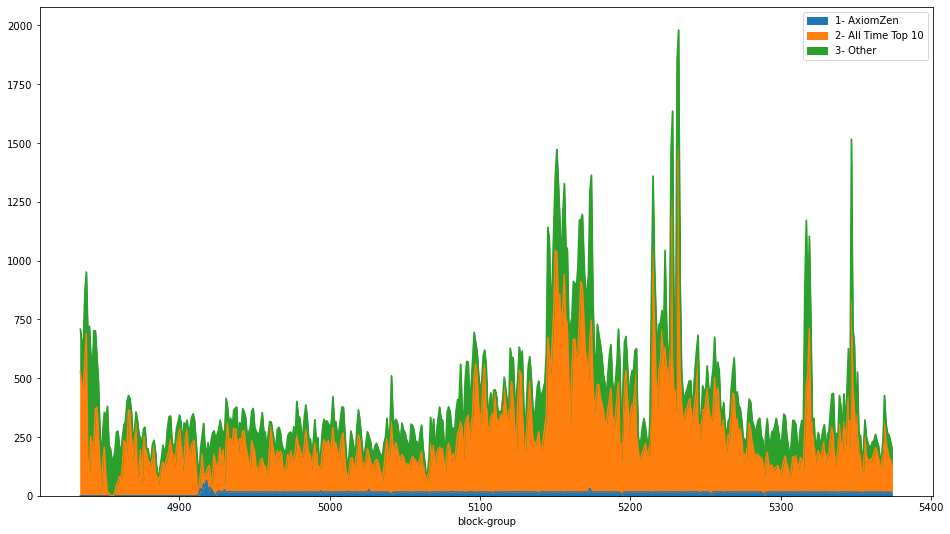

In [38]:
areaplot.plot.area(figsize=(16, 9))
plt.legend(loc=1)

In [ ]:
movingTopFiveMidwives = births.groupby(['block-group','midwife']).data.count().reset_index().\
                sort_values(by=['block-group','data'],ascending=False).groupby(['block-group']).head(5)
movingTopFiveMidwives = set(movingTopFiveMidwives.midwife.values)
len(movingTopFiveMidwives)